In [1]:
cd ..

/home/boyochen/dltc


In [2]:
import numpy as np
import h5py
import pandas as pd
import os

In [3]:
from modules.feature_generator import load_dataset

2021-12-04 00:56:31.082972: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
/home/boyochen/.local/share/virtualenvs/dltc-EZrvkknN/lib/python3.8/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.4.0 and strictly below 2.7.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.3.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [4]:
data_folder = 'TCSA_data/'
train_data = load_dataset(data_folder, 'train', coordinate='polar')
valid_data = load_dataset(data_folder, 'valid', coordinate='polar')
test_data = load_dataset(data_folder, 'test', coordinate='polar')

In [5]:
from modules.training_helper import get_tensorflow_datasets
datasets = get_tensorflow_datasets(
    data_folder='TCSA_data/',
    batch_size=5,
    shuffle_buffer=10000,
    prefetch_buffer=5,
    good_VIS_only=True,
    valid_profile_only=True,
    coordinate='polar'
)

2021-12-04 00:57:41.888195: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2021-12-04 00:57:41.986843: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:02:00.0 name: GeForce GTX 1080 Ti computeCapability: 6.1
coreClock: 1.582GHz coreCount: 28 deviceMemorySize: 10.92GiB deviceMemoryBandwidth: 451.17GiB/s
2021-12-04 00:57:41.987927: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 1 with properties: 
pciBusID: 0000:03:00.0 name: GeForce GTX 1080 Ti computeCapability: 6.1
coreClock: 1.582GHz coreCount: 28 deviceMemorySize: 10.92GiB deviceMemoryBandwidth: 451.17GiB/s
2021-12-04 00:57:41.989011: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 2 with properties: 
pciBusID: 0000:81:00.0 name: GeForce GTX 1080 Ti computeCapability: 6.1
coreClock: 1.582GHz coreCount: 28 deviceMemorySize: 10.92GiB deviceMemoryBandwidth: 451.17GiB/s
2

In [6]:
datasets['train']

<PrefetchDataset shapes: ((None, 180, 103, 4), (None, 9), (None, 151), (None, 1), (None, 1)), types: (tf.float32, tf.float32, tf.float32, tf.float32, tf.float32)>

In [43]:
import matplotlib.pyplot as plt
from modules.image_processor import polar2cart

def sample_4_channel(image_matrix, fig_high, target_index=0):
    fig = plt.figure(figsize=(12, fig_high))
    polar_image = image_matrix[target_index]
    cart_image = polar2cart(polar_image)
    for j, target_image in enumerate([polar_image, cart_image]):
        for i, channel_name in enumerate(['IR1', 'WV', 'VIS', 'PMW']):
            plt.subplot(2, 4, i+1+4*j)
            plt.imshow(target_image[:, :, i], cmap='gray')
            plt.title('(%s) %s' % (chr(97+i), channel_name))

    plt.show()

tf.Tensor(
[[90.      ]
 [40.      ]
 [26.762678]
 [16.431988]
 [15.782245]], shape=(5, 1), dtype=float32)


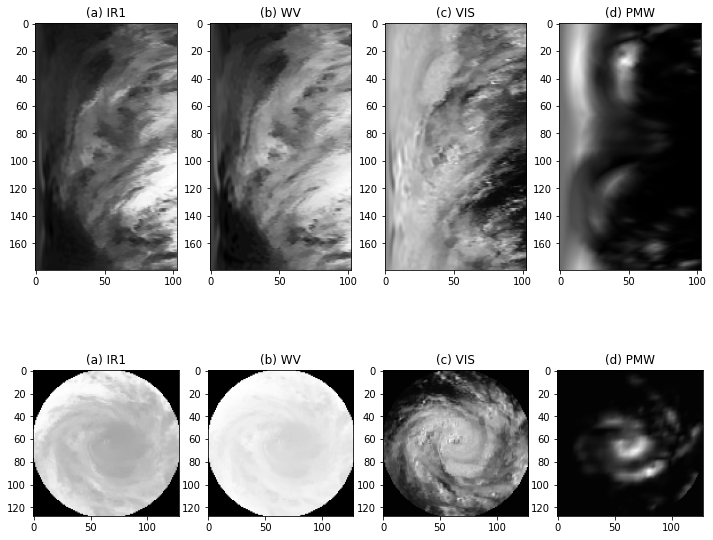

In [47]:
for (new_images, features, profiles, Vmax, R34) in datasets['train']:
    break

print(Vmax)
sample_4_channel(new_images, fig_high=10, target_index=0)

In [10]:
from modules.model_constructor import create_model_by_experiment_path_and_stage

experiment_path = 'experiments/GAN_profiler_experiments/five_stage_training_strong_GDP.yml'
sub_exp_name = 'profiler_finetune_stage'
model = create_model_by_experiment_path_and_stage(experiment_path, sub_exp_name)

In [11]:
from modules.training_helper import replace_original_channel_with_generation
new_datasets = replace_original_channel_with_generation(
    datasets, model.generator,
    replace_VIS=True,
    replace_PMW=True
)

2021-12-04 00:59:58.029252: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudnn.so.7
2021-12-04 00:59:59.963384: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10


tf.Tensor(
[[125.      ]
 [ 45.      ]
 [ 40.      ]
 [ 45.      ]
 [  4.057159]], shape=(5, 1), dtype=float32)


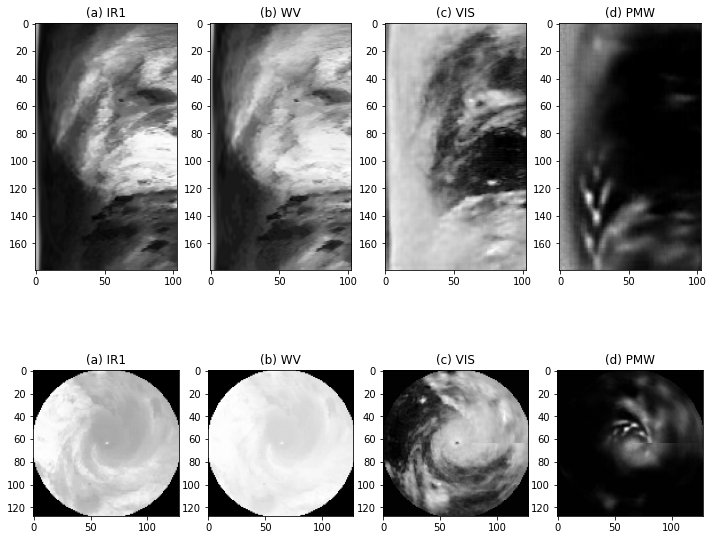

In [50]:
for (new_images, features, profiles, Vmax, R34) in new_datasets['train']:
    break

print(Vmax)
sample_4_channel(new_images, fig_high=10, target_index=0)

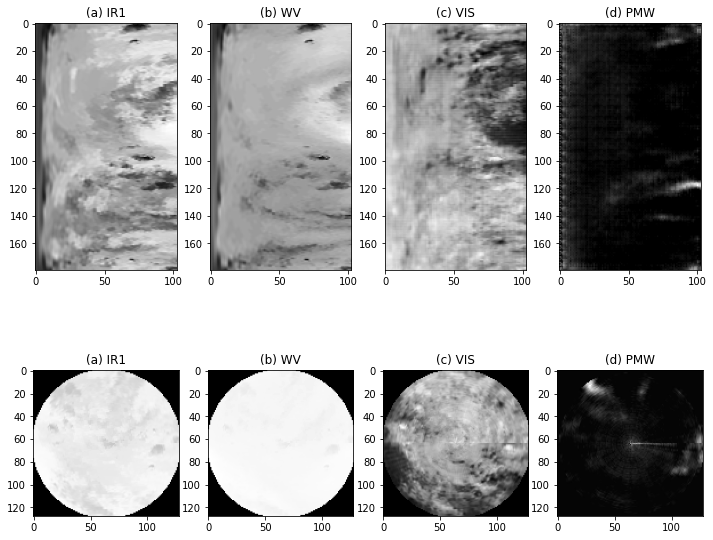

In [51]:
sample_4_channel(new_images, fig_high=10, target_index=4)

In [3]:
from modules.feature_generator import crop_center

data_folder = 'TCSA_data/'
file_list = ['TCSA.h5']

# collect matrix from every file in the list
matrix = []
for file_name in file_list:
    file_path = data_folder+file_name
    if not os.path.isfile(file_path):
        print('file %s not found! try to download it!' % file_path)

    with h5py.File(file_path, 'r') as hf:
        tmp = hf['matrix'][:]
        center_cropped_matrix = crop_center(hf['matrix'][:], 128)
        matrix.append(center_cropped_matrix)

image_matrix = np.concatenate(matrix, axis=0)
print(image_matrix.shape)

# collect info from every file in the list
info_df = pd.concat([
    pd.read_hdf(data_folder+file_name, key='info', mode='r')
    for file_name in file_list
]).reset_index(drop=True)

info_df

2021-11-12 03:21:35.218817: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
/home/boyochen/.local/share/virtualenvs/dltc-EZrvkknN/lib/python3.8/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.4.0 and strictly below 2.7.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.3.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


ImportError: cannot import name 'crop_center' from 'modules.feature_generator' (/home/boyochen/dltc/modules/feature_generator.py)

In [65]:
L = []
step = 100
dataset = test_data
for i in range(0, dataset['image'].shape[0], step):
    print(i, end='\r')
    new_image = model.generate_noon_images(dataset['image'][i:i+step], dataset['feature'][i:i+step].to_numpy(dtype='float32'), training=False)
    L.append(new_image.numpy())

In [66]:
tmp = np.concatenate(L)
tmp.shape

(10952, 180, 103, 4)

In [67]:
dataset['image'].shape

(10952, 180, 103, 4)

In [68]:
test_data['image'] = tmp

In [69]:
data_folder = 'TCSA_fake/'
phase = 'test'
coordinate = 'polar'
pickle_path_format = '%sTCSA.%s.%s.pickle'
pickle_path = pickle_path_format % (data_folder, phase, coordinate)
pickle_path

'TCSA_fake/TCSA.test.polar.pickle'

In [70]:
import pickle
with open(pickle_path, 'wb') as save_file:
    pickle.dump(test_data, save_file, protocol=5)

In [23]:
new_image = model.generate_noon_images(train_data['image'], train_data['feature'].to_numpy(dtype='float32'), training=False)

2021-11-12 03:39:51.439217: W tensorflow/core/common_runtime/bfc_allocator.cc:431] Allocator (GPU_0_bfc) ran out of memory trying to allocate 15.13GiB (rounded to 16251125760)requested by op GatherV2
Current allocation summary follows.
2021-11-12 03:39:51.439268: I tensorflow/core/common_runtime/bfc_allocator.cc:970] BFCAllocator dump for GPU_0_bfc
2021-11-12 03:39:51.439280: I tensorflow/core/common_runtime/bfc_allocator.cc:977] Bin (256): 	Total Chunks: 1, Chunks in use: 1. 256B allocated for chunks. 256B in use in bin. 8B client-requested in use in bin.
2021-11-12 03:39:51.439287: I tensorflow/core/common_runtime/bfc_allocator.cc:977] Bin (512): 	Total Chunks: 0, Chunks in use: 0. 0B allocated for chunks. 0B in use in bin. 0B client-requested in use in bin.
2021-11-12 03:39:51.439295: I tensorflow/core/common_runtime/bfc_allocator.cc:977] Bin (1024): 	Total Chunks: 1, Chunks in use: 1. 1.2KiB allocated for chunks. 1.2KiB in use in bin. 1.0KiB client-requested in use in bin.
2021-11-

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run GatherV2: Dst tensor is not initialized. [Op:GatherV2]

In [ ]:
from modules.feature_generator import data_cleaning_and_organizing

image_matrix, label_df, feature_df = data_cleaning_and_organizing(image_matrix, info_df)

print(label_df.shape)
print(feature_df.shape)
print(image_matrix.shape)

In [ ]:
feature_df['minutes_to_noon'] = 0

In [ ]:
feature_df['hour_cos'] = -0.965926
feature_df['hour_sin'] = 0.2588190

In [ ]:
image = crop_center(image_matrix.astype(np.float32), 64)
feature = feature_df.to_numpy(dtype='float32')
label = label_df[['Vmax']].to_numpy(dtype='float32')

for piece in [image, feature, label]:
    print(piece.shape)

In [ ]:
noon_image = model.generate_noon_image(image, feature, training=False)

noon_image.shape

In [ ]:
def scale_to_0_1(matrix):
    out = matrix - matrix.min()
    tmp_max = out.max()
    if tmp_max != 0:
        out /= tmp_max
    return out

def stick_into_big_matrix(image, target_index, width=4, target_channel_idx=2):
    random_select_num = width**2 - len(target_index)
    bound = image.shape[0]
    random_index = [np.random.randint(bound) for i in range(random_select_num)]
    selected_index = list(range(random_select_num)) #target_index+random_index
    print(selected_index)
    selected_image = image.numpy()[selected_index]
    list_of_list_of_images = [
        [
            (selected_image[i*width+j, :, :, target_channel_idx])
            for j in range(width)
        ] for i in range(width)
    ]
    list_of_lines = [
        np.concatenate(
            list_of_images, axis=1
        ) for list_of_images in list_of_list_of_images
    ]
    return np.concatenate(list_of_lines, axis=0)


In [ ]:
import matplotlib.pyplot as plt

big_matrix = stick_into_big_matrix(noon_image, [], width=9, target_channel_idx=2)

plt.figure(figsize=(10,10))
plt.imshow(big_matrix, cmap='gray')
plt.show()

In [ ]:
import h5py

with h5py.File('sample_generation_4channel.h5', 'w') as hf:
    hf.create_dataset('generated_mmatrix', data=noon_image)

with h5py.File('sample_generation_4channel.h5', 'r') as hf:
    generated_matrix = hf['generated_mmatrix'][:]

In [ ]:
print(type(generated_matrix))
print(generated_matrix.dtype)
print(generated_matrix.shape)

In [13]:
plt.figure(figsize=(10,10))
plt.imshow(big_matrix, cmap='gray')
plt.show()

array([[[ 2.10679993e+02,  2.08889999e+02,  3.44000012e-01,
          7.12003790e-22],
        [ 2.07842285e+02,  2.08747086e+02,  3.56406689e-01,
         -4.04567801e-09],
        [ 2.05771881e+02,  2.08320557e+02,  3.86853158e-01,
          7.27238980e-09],
        ...,
        [ 2.15008728e+02,  2.16105331e+02,  6.26400292e-01,
          1.80583153e+01],
        [ 2.35612015e+02,  2.23906967e+02,  5.91181517e-01,
          1.83410530e+01],
        [ 2.45234955e+02,  2.27695953e+02,  5.74190259e-01,
          1.83275890e+01]],

       [[ 2.10679993e+02,  2.08889999e+02,  3.44000012e-01,
          7.12003790e-22],
        [ 2.07807037e+02,  2.08654907e+02,  3.57195079e-01,
         -2.44522571e-08],
        [ 2.05671722e+02,  2.08157837e+02,  3.88730317e-01,
          8.85990303e-08],
        ...,
        [ 2.31928116e+02,  2.22095718e+02,  4.66415077e-01,
          1.89164429e+01],
        [ 2.39270660e+02,  2.25321091e+02,  4.10356641e-01,
          1.84350224e+01],
        [ 2.429